[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jochemvankempen/demos-data-science/blob/master/signal-detection-AUROC.ipynb)

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jochemvankempen/demos-data-science/HEAD?filepath=signal-detection-AUROC.ipynb)

# Signal-detection-AUROC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Here I go over computation of the area under the receiver operating characteristic (AUROC). 

Stemming from signal detection theory (Green and Swets, 1966), this measure represents the difference between two distributions as a single scalar value, taking into account both the average difference in magnitude as well as the variability of each distribution. 
This value indicates how well an ideal observer would be able to distinguish between two distributions, for example the neural response when attention is directed towards versus away from its RF. 

It is computed by iteratively increasing the threshold and computing the proportion (from the first sample to the threshold) of hits and false alarms (FA), i.e. the correct and false classification as samples belonging to one of the distributions. The ROC curve is generated by plotting the proportions of hits against the proportion of FAs, and AUROC is taken as the area under the ROC curve. An AUROC of 0.5 indicates that the two distributions were indistinguishable, whereas an AUROC of 0 or 1 indicates that the two distributions were perfectly separable.

<img src="./images/AUROC_schematic.svg" rect width="80%" height="80%" fill="white"/>
*Graphic representation of receiver operating characteristic (ROC) computation. (**a**) Schematic illustrating the classification of samples belonging to the blue (hit) and red (false alarm, FA) distribution. The proportion of hits and FAs is computed for each iterative updating of the threshold. (**b-c**) Two sets of distributions, probability density functions (**b**) and their accompanying ROC curves (**c**) for which the blue and red distribution are relatively easy (top) or hard (bottom) to classify. An AUROC value of 0.5 indicates that the two distributions are indistinguishable, in which case the ROC curve would fall along the unity line.*

In [2]:
# define parameters
num_samples = 1000

# define means and standard deviations of example distributions
dist_mu = np.array([1.5, 2])
dist_sigma = np.array([0.5, 0.2])


In [3]:
# create distributions
x = np.linspace(0,4,100)

dist1 = np.random.normal(size=[num_samples], loc=dist_mu[0], scale=dist_sigma[0])
dist2 = np.random.normal(size=[num_samples], loc=dist_mu[1], scale=dist_sigma[1])

# concatenate
dists = np.concatenate((dist1[:,np.newaxis],dist2[:,np.newaxis]), axis=1)

print(np.shape(dist1))
print(np.shape(dists))

# get analytic distributions
dist1_analytic = stats.norm(loc=dist_mu[0], scale=dist_sigma[0]).pdf(x)
dist2_analytic = stats.norm(loc=dist_mu[1], scale=dist_sigma[1]).pdf(x)

(1000,)
(1000, 2)


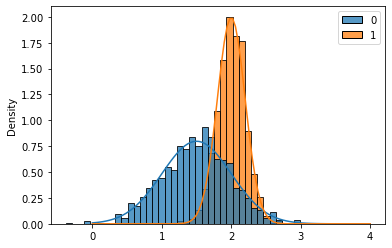

In [4]:
# plot
sns.histplot(
    dists,
    stat='density',
    multiple='layer',
    common_norm=False)
# Plot the analytic distribution on top
sns.lineplot(x=x, y=dist1_analytic)
sns.lineplot(x=x, y=dist2_analytic)
plt.show()

In [5]:
# define AUROC function
def AUROC(data, classidx):
    # AUROC(data, classidx)
    #
    # Compute area under receiver operating characteristic curve
    #
    # Parameters
    # ----------
    # data : numpy array of floats
    #   vector containing a set of samples
    # classidx : numpy array of int
    #   vector with membership of each data point in the class 0 or 1 (binary only)
    #
    # Returns
    # -------
    # area : float
    #   float indicating area under receiver operating characteristic curve
    # hit : numpy array of floats
    #   array with proportion of hits at varying thresholds
    # fa : numpy array of floats
    #   array with proportion of false alarms at varying thresholds
    # 
     
    # check input
    num_samples = np.shape(data)[0];
    
    assert np.shape(data)[0] == np.shape(classidx)[0], 'data and class labels should have the same shape'
    assert np.all((classidx==0) | (classidx==1)), 'class labels should be either 0 or 1'
    
    # sort data, class
    sort_idx = np.argsort(data,axis=0)
    sort_data = data[sort_idx]
    sort_class = classidx[sort_idx]
    
    # init
    hit = np.zeros([num_samples])
    fa = np.zeros([num_samples])
    
    # get number of samples per class
    num_samples1 = np.sum(sort_class==1)
    num_samples2 = np.sum(sort_class==0)
    
    # loop over samples (thresholds) and compute proportion of hits and false alarms
    for ithresh in range(num_samples):
        hit[num_samples-ithresh-1] = np.sum(sort_class[ithresh:num_samples]==1)/num_samples1 # number of hits
        fa[num_samples-ithresh-1]  = np.sum(sort_class[ithresh:num_samples]==0)/num_samples2 # number of false alarms
    
    # area under curve
    delta_fa = np.diff(fa)
    area = np.dot(delta_fa,hit[1:])
    
    return area, hit, fa

AUROC = 0.8379909999999999


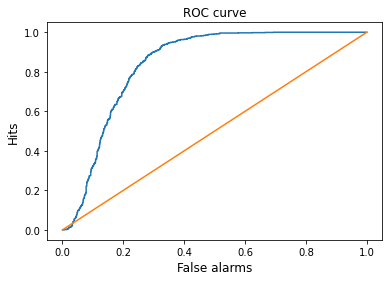

In [6]:
# make into single dimensional vector
data = np.squeeze(np.reshape(dists, (num_samples*2,1),order='F')) 

# define class membership
classidx = np.concatenate((np.zeros(num_samples),np.ones(num_samples)))

# compute AUROC
area,hit,fa = AUROC(data, classidx)

# print and plot
print(f'AUROC = {area}')

plt.plot(fa,hit)
plt.plot([0, 1], [0, 1])
plt.xlabel("False alarms", size = 12) 
plt.ylabel("Hits", size = 12) 
plt.title('ROC curve')
plt.show()
